In [1]:
%load_ext lab_black
%load_ext autotime

import drnb.embed.pipeline as pl

time: 9.02 s (started: 2023-03-12 21:31:56 -07:00)


# Leopold: Lightweight Estimate of Preservation of Local Density

I invented this method for [uwot](https://jlmelville.github.io/uwot/leopold.html) as an approximation to [densMAP](https://doi.org/10.1038/s41587-020-00801-7). The version here differs slightly in implementation to that in uwot but is similar in spirit: the nearest neighbor distances are used to estimate the local density at each point and a per-pair "precision" parameter, $\beta$ is applied to the Cauchy kernel. I think that similar approach is used by [annembed](https://github.com/jean-pierreBoth/annembed). No attempt is made to "match" high and low-dimensional densities in any kind of consistent scheme that would take account of the difference of distance vs volume in different intrinsic and embedded dimensions or anything like that. All I want to see is that if two clusters exist in the ambient dimension and one is more dense than the other, then in the embedded space the more dense cluster should be smaller than the larger cluster -- or at least the more dense cluster is smaller than it would look with plain UMAP.

Additionally I add a degree-of-freedom parameter, $\alpha$ to give rise to a heavy-tail kernel like that used by [Kobak and co-workers](https://arxiv.org/abs/1902.05804) with t-SNE.

The kernel is therefore:

$$
w_{ij} = 1/\left(1 + \frac{\beta_{ij}}{\alpha} d_{ij}^2\right)^\alpha
$$


The gradients are:

$$
\frac{\partial{C_{\mathrm{leopold}}^+}}{\partial{\mathbf{y_i}}} = 2 \beta_{ij} w_{ij}^{1/\alpha}\left(\mathbf{y_i} - \mathbf{y_j}\right) 
= \frac{2 \beta_{ij}}{\left(1 + \frac{\beta}{\alpha} d_{ij}^2\right)}\left(\mathbf{y_i} - \mathbf{y_j}\right)
$$

$$
\frac{\partial{C_{\mathrm{leopold}}^-}}{\partial{\mathbf{y_i}}} =  \frac{-2 \beta_{ij} w_{ij}^{\left(\alpha + 1 \right) / \alpha}}{1 - w_{ij} + \varepsilon}\left(\mathbf{y_i} - \mathbf{y_j}\right)
= \frac{-2 \beta_{ij} w_{ij}}{\left(1 + \frac{\beta}{\alpha} d_{ij}^2\right)\left(1 - w_{ij} + \varepsilon \right)}\left(\mathbf{y_i} - \mathbf{y_j}\right)
$$

The second versions are probably a bit more efficient because they save on some power calculations. For the repulsive gradient, $\varepsilon = 0.001$ and is there to prevent division by zero just like in UMAP.

## Calculating the precision

This following bit seems like a lot of work but the idea is conceptually simple: use the nearest neighbor distances to get an idea of the local density around each point. Subsequent steps are numerical busywork: scale the densities so that they fit into a numerical range that won't cause horrific under/overflow and other instabilities. Finally, allow a parameterization that smoothly goes from "ignore local density" to "strongly use local density".

The precision calculated as follows:

1. Calculate the average nearest neighbor distance for each point: $r_i$
2. The initial precision is $\beta_{i}^{\prime} = 1 / r_i$
3. The initial precisions are scaled (let's call these ones $\beta_{i}^{*}$) be in the range $\left[\sqrt{10^{-2}}, \sqrt{100}\right]$ (by basic range scaling). The square root is there so that multiplying $\beta_i$ and $\beta_j$ gives the harmonic mean and ranging betweeen $10^{-2}$ and $100$ was chosen arbitrarily to give something that seemed numerically stable.
4. Finally the scaled precisions are scaled again to form a weighted average between $\beta_i^{*}$ and having all $\beta_i=1$: $\beta_i = \left(1 - d\right) + d\beta_i^{*}$. The `dens_scale` parameter controls $d$ in the implementation: `dens_scale=0.0` is equivalent to all $\beta_i=1$, i.e. like
normal UMAP. `dens_scale=1.0` uses the full range of $\beta_{i}^{*}$. So you can control how much you want the local density to affect the results by
setting `dens_scale` appropriately.

## Choosing $\alpha$

The degree-of-freedom parameter, $\alpha$ is global and has to be chosen manually. There's no reason it couldn't be point-wise like $\beta$, I just haven't thought of a good way to assign it yet (maybe there are some good ideas to take from [SpaceMAP](https://github.com/zuxinrui/SpaceMAP)). The `dof` parameter controls it. Set `dof=1.0` to get Cauchy-kernel-like behavior. Larger `dof` gives progressively more Gaussian-like behavior, but above `dof=10.0` I can't see much difference. Smaller values will give even more heavy-tailed behavior which tends to make any clusters smaller or break them up into smaller structures. Things start to breakdown with values smaller than `dof=0.5`.

## Other deviations from UMAP

* To make the implementation easier I don't generate any high-dimensional affinities, so no perplexity-like calibration. Effectively all neighbor affinities are 1.
* This also means no sampling scheme: every edge gets sampled in every epoch and gets the same number of repulsive interactions calculated.
* The symmetrization step on the input affinities takes an unweighted adjacency matrix and carries out an 'OR' operation on it and its transpose: if `i` is a neighbor of `j` or `j` is a neighbor of `i`, then both `(i, j)` and `(j, i)` appear in the symmetrized matrix. This effectively converts the nearest neighbor graph to an undirected neighbor graph.
* No asynchronous Hogwild!-style optimization: the gradients are accumulated in each epoch and then [Adam](https://arxiv.org/abs/1412.6980) is used as the optimizer, similar to what [PaCMAP](https://arxiv.org/abs/2012.04456) does. This is probably a bit less efficient, but a bit more stable.

## MNIST

For the MNIST digits, most of the clusters have a pretty similar "density" if you measure by the UMAP or t-SNE-style calibration. The big exception is the `1` cluster, which is noticeably more dense than the others. This isn't something I see reflected in most embeddings. [densMAP](https://umap-learn.readthedocs.io/en/latest/densmap_demo.html) does it. The [annembed examples](https://github.com/jean-pierreBoth/annembed#results) also show it. Weirdly, [the trimap example](https://github.com/eamid/trimap#examples) makes the one cluster much *bigger* than the others, which I have never understood.

[21:33:05] INFO     Loading faiss with AVX2 support.                                                   ]8;id=149022;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=32716;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=820364;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=859957;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=877091;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=206886;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=587700;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=962967;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

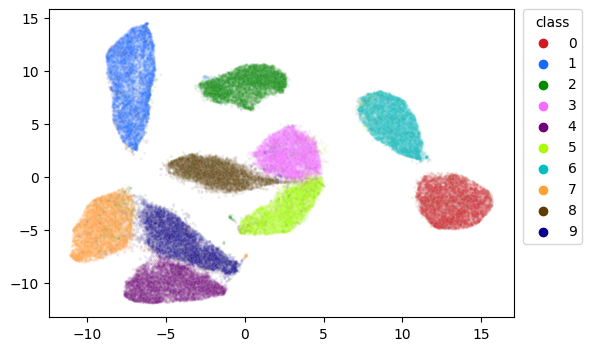

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.61236, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.33677979361706284, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.10114190476190475, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.1749014285714286, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2690457142857143, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1min 7s (started: 2023-03-12 21:32:05 -07:00)


In [2]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=1.0, dens_scale=0.0, n_neighbors=15),
    dataset="mnist",
)

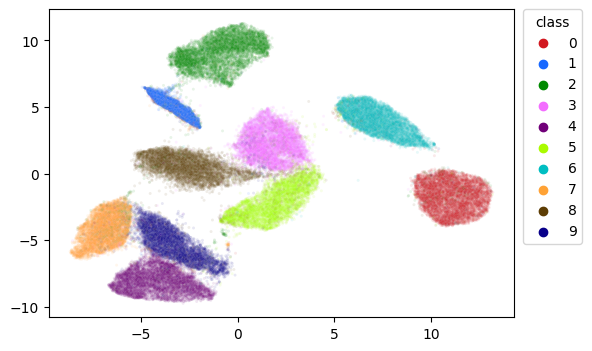

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6341028571428571, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.43116249404923473, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.10416380952380952, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.17805485714285718, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2723525714285714, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 58.5 s (started: 2023-03-12 21:33:13 -07:00)


In [3]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=1.0, dens_scale=0.5, n_neighbors=15),
    dataset="mnist",
)

Phew, the `1` cluster got smaller. Does it also work with `dof` value closer to a Gaussian?

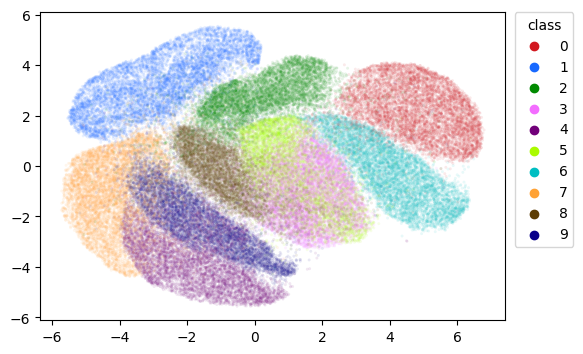

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6378142857142857, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.4171963168631272, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.06051809523809523, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.115538, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.19210200000000002, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 57.9 s (started: 2023-03-12 21:34:11 -07:00)


In [4]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=10.0, dens_scale=0.0, n_neighbors=15),
    dataset="mnist",
)

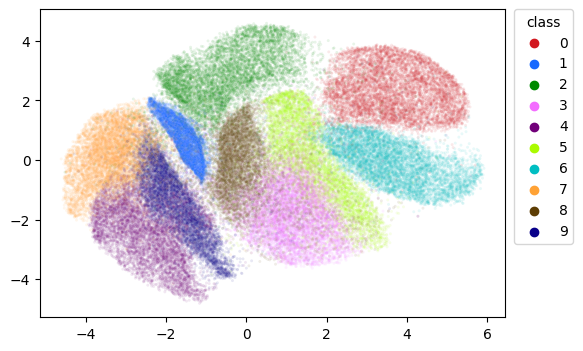

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6684628571428571, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.5317123505166145, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.07180666666666667, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.1331511428571429, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.21753285714285714, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 59.2 s (started: 2023-03-12 21:35:09 -07:00)


In [5]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=10.0, dens_scale=0.5, n_neighbors=15),
    dataset="mnist",
)

This is still not a very nice looking result compared to the heavier-tailed version, but the `1` cluster is still able to be resized compared to the others.

And what about going the other way, with an even heavier tail?

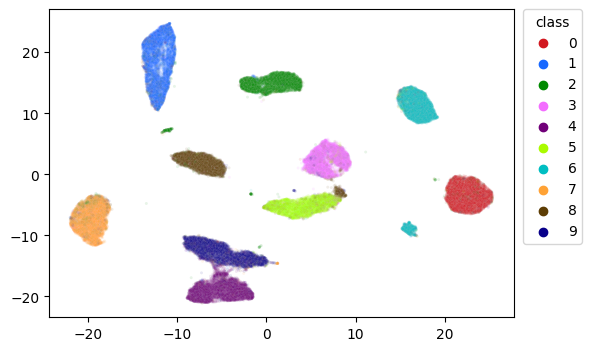

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5980514285714287, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.2928628547299469, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.12026761904761905, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.19514600000000004, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2846511428571428, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1min (started: 2023-03-12 21:36:09 -07:00)


In [6]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=0.5, dens_scale=0.0, n_neighbors=15),
    dataset="mnist",
)

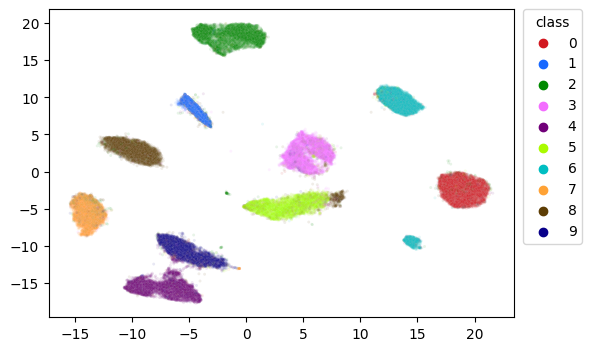

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6260542857142858, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.4073717112670116, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.12246190476190474, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.1975637142857143, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.28674409523809524, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 60 s (started: 2023-03-12 21:37:09 -07:00)


In [7]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=0.5, dens_scale=0.5, n_neighbors=15),
    dataset="mnist",
)

Visually, the `1` cluster is smaller (compare to the `2` and the `8` cluster). However, for both the `dof=0.5` cases, the clusters of digits are broken up. Starting the optimization with `dof=1.0` can help. In addition the `decay_alpha=False` optimization argument is used for the initial stage which doesn't anneal the learning rate. This usually results in fuzzier looking results but tends to give a more reliable optimization overall so as we follow up with an optimization that *does* reduce the learning rate over the course of the optimization it's useful to get the most out of the initial stage of the optimization:

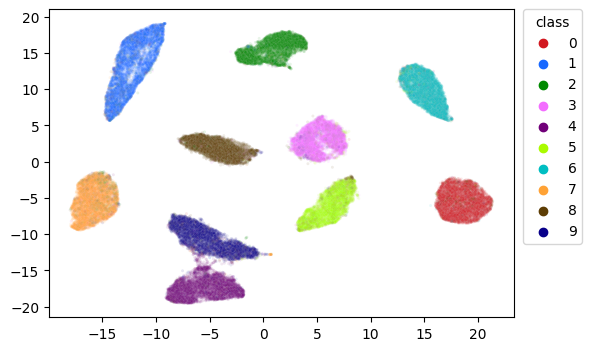

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6066428571428572, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.32007374163400265, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.11733333333333332, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.19304400000000005, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2835821904761905, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 58.7 s (started: 2023-03-12 21:38:09 -07:00)


In [8]:
pl.standard_eval(
    [
        pl.embedder(
            "leopold",
            params=dict(
                dof=1.0,
                dens_scale=0.0,
                n_neighbors=15,
                n_epochs=200,
                optargs=dict(decay_alpha=False),
            ),
        ),
        pl.embedder(
            "leopold",
            params=dict(dof=0.5, dens_scale=0.0, n_neighbors=15, n_epochs=300),
        ),
    ],
    dataset="mnist",
)

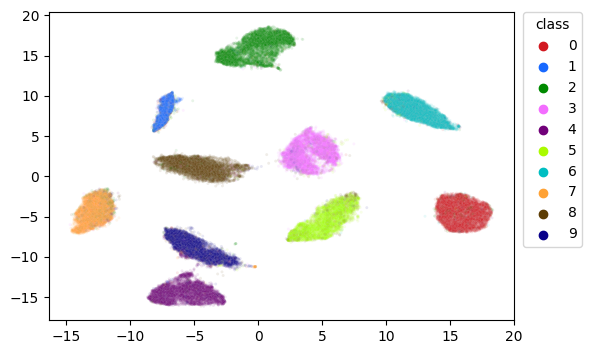

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6230142857142856, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3942568514208264, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.1203095238095238, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.19635971428571428, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2866593333333333, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 59.9 s (started: 2023-03-12 21:39:08 -07:00)


In [9]:
pl.standard_eval(
    [
        pl.embedder(
            "leopold",
            params=dict(
                dof=1.0,
                dens_scale=0.0,
                n_neighbors=15,
                n_epochs=200,
                optargs=dict(decay_alpha=False),
            ),
        ),
        pl.embedder(
            "leopold",
            params=dict(dof=0.5, dens_scale=0.5, n_neighbors=15, n_epochs=300),
        ),
    ],
    dataset="mnist",
)

These look better visually even if there isn't a huge change in the metrics.

## 2D clusters

A synthetic 2D dataset consisting of two clusters embedded in some uniformly distributed noise, from a [google colab notebook by Pavlin Poličar](https://colab.research.google.com/drive/1-8vLka6Cwj8rE4G48w0C7kXqQJLkZrQH?usp=sharing). Here is the actual ground truth:

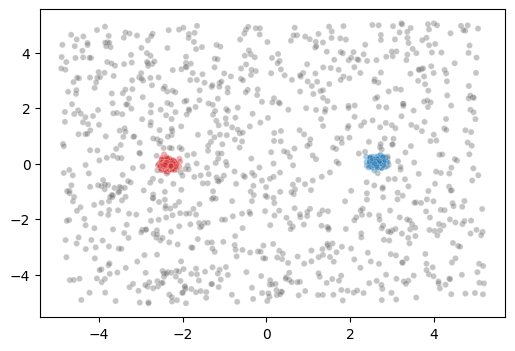

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=1.0, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9999999999999841, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.9999555555555556, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=1.0, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=1.0, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1.94 s (started: 2023-03-12 21:40:08 -07:00)


In [10]:
pl.standard_eval(
    method="pca",
    dataset="embdensity",
)

And here are some runs with leopold with and without density scaling and using the Cauchy versus a more Gaussian-like kernel. The Gaussian kernel should be a bit more appropriate here as a 2D dataset shouldn't need a heavy-tailed kernel.

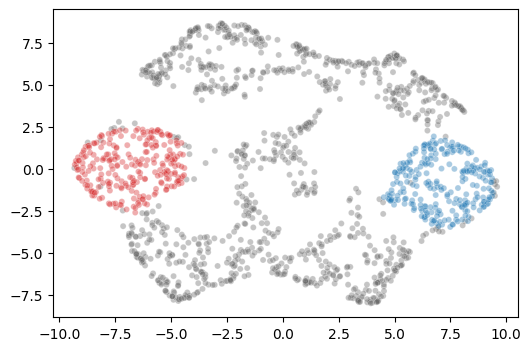

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.8576, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.8402744459582806, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.8003111111111111, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.8095466666666666, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8125999999999999, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 2.09 s (started: 2023-03-12 21:40:10 -07:00)


In [11]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=1.0, dens_scale=0.0, n_neighbors=15),
    dataset="embdensity",
)

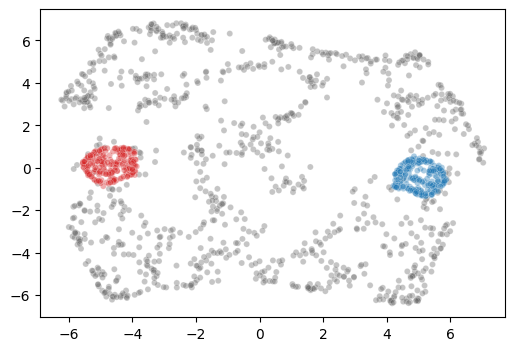

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.9157333333333334, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.944142405055746, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7985777777777778, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.82268, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8690133333333333, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 2.03 s (started: 2023-03-12 21:40:12 -07:00)


In [12]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=1.0, dens_scale=0.2, n_neighbors=15),
    dataset="embdensity",
)

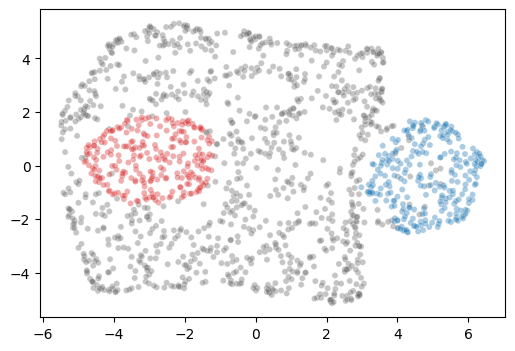

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.8709333333333334, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.8613972625333264, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7680888888888888, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.7804399999999999, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.78524, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 2.06 s (started: 2023-03-12 21:40:14 -07:00)


In [13]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=10.0, dens_scale=0.0, n_neighbors=15),
    dataset="embdensity",
)

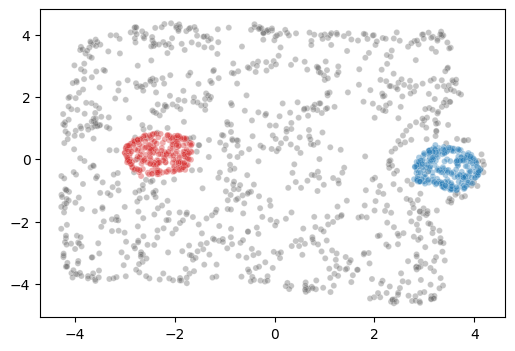

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.9296000000000001, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9561302983352005, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.8141777777777779, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.8464666666666666, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8770222222222221, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 2.02 s (started: 2023-03-12 21:40:16 -07:00)


In [14]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=10.0, dens_scale=0.2, n_neighbors=15),
    dataset="embdensity",
)

The `dof=10.0` results seem to do better at avoiding tearing the more uniform grey points, but the blue cluster poking out of the side is odd. Maybe we can be more aggressive with `dens_scale`? Let's use the full range of densities, which seems like it would be helpful here as we know the blue and red cluster have a much smaller density than the grey points:

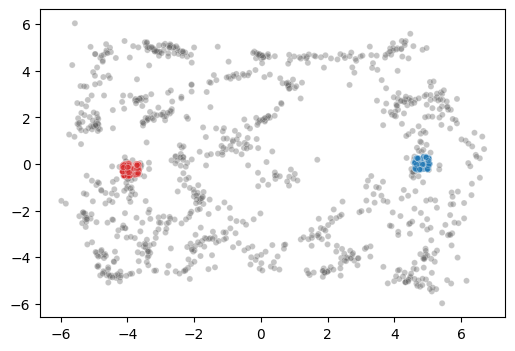

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.8953333333333333, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9377108287876401, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7578222222222224, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.7729333333333334, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8508933333333334, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1.96 s (started: 2023-03-12 21:40:18 -07:00)


In [15]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=1.0, dens_scale=1.0, n_neighbors=15),
    dataset="embdensity",
)

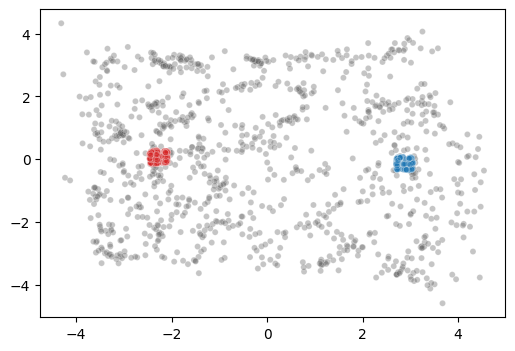

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.9294666666666667, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9650446097475689, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7930222222222224, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.8191199999999998, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8914533333333332, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1.96 s (started: 2023-03-12 21:40:20 -07:00)


In [16]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=10.0, dens_scale=1.0, n_neighbors=15),
    dataset="embdensity",
)

Again, the `dof=10.0` result is slightly better and the blue cluster isn't bulging out of the enclosing grey background points. In UMAP-like methods, where there is a "containment"-like relationship in the data, like we have here with the small clusters contained in the grey uniform points, increasing `n_neighbors` can also help capture longer-range changes in density. Admittedly, it's not a very efficient way to do this and the biggest effect is usually with synthetic low-dimensional datasets like this one. Anyway, let's see what happens with `n_neighbors=50`:

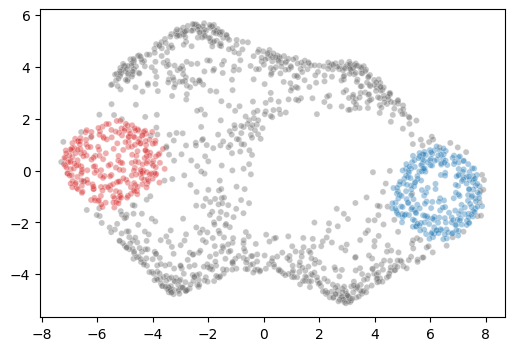

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.8292000000000002, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.7745235644663491, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7207999999999999, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.8066000000000001, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8120622222222221, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 4.09 s (started: 2023-03-12 21:40:22 -07:00)


In [17]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=1.0, dens_scale=0.0, n_neighbors=50),
    dataset="embdensity",
)

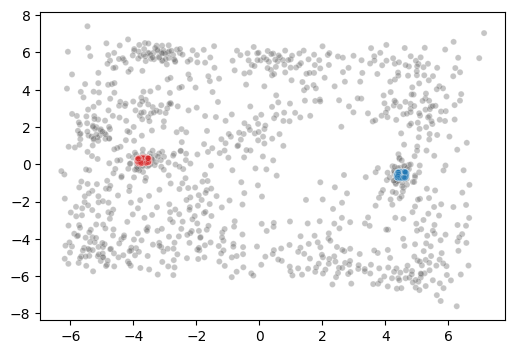

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.9281333333333333, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9742245058148838, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7059555555555556, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.789, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8535422222222223, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 4.01 s (started: 2023-03-12 21:40:26 -07:00)


In [18]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=1.0, dens_scale=1.0, n_neighbors=50),
    dataset="embdensity",
)

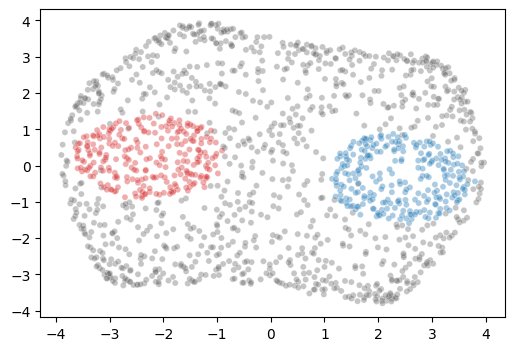

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.9077333333333333, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9229645672749707, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7331555555555556, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.8075200000000001, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8215600000000001, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 4.04 s (started: 2023-03-12 21:40:30 -07:00)


In [19]:
pl.standard_eval(
    method="leopold",
    params=dict(dof=10.0, dens_scale=0.0, n_neighbors=50),
    dataset="embdensity",
)

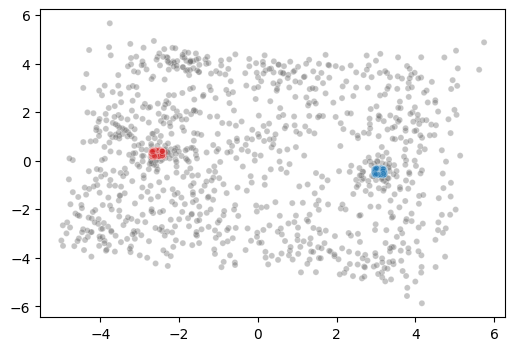

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.9481333333333334, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9809401917122028, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.7466666666666667, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.8224533333333334, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.8910399999999999, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 4.01 s (started: 2023-03-12 21:40:34 -07:00)


In [20]:
pl.standard_eval(
    method="leopold",
    dataset="embdensity",
    params=dict(dof=10.0, dens_scale=1.0, n_neighbors=50),
)

`dof=1.0` results still tend to clump the grey points too much. Using `dens_scale` helps. But `dof=10.0` is an improvement. Meanwhile the `dens_scale=0.0` results for either value of `dof` seem to cause the clusters to form a ring-like shape. So `dens_scale` is certainly helpful there.

For this low-dimensional dataset, while being of less importance than setting `dens_scale`, manually setting a value of `dof` that is larger than the typical Cauchy kernel seems like it can be helpful.